In [201]:
from sklearn.neighbors import DistanceMetric
from math import radians
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse
import torch
from torch.utils.dlpack import to_dlpack, from_dlpack
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_undirected, is_undirected, convert
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
#from torch_geometric.nn import GCNConv
import torch.nn.functional as F
pd.options.mode.chained_assignment = None

def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))  

### Generate Sample Data

In [210]:
cities_df = pd.DataFrame({
    'house':['h1','h2','h3','h4','h5','h6','t1','t2','t3'],
    'lat':[12.9716,19.076,28.7041,22.5726,13.0827,23.2599,12.9713,19.003,28.7048],
    'lon':[77.5946,72.877,77.1025,80.639,80.2707,77.4126,77.5920,72.8605,77.2000],
    'x1':[20,35,24,33,35,18,19,32,23],
    'x2':[5,5,7,13,16,21,6,6,6],
    'y':[1200,1500,2000,1780,1450,3000,1300,1600,1800]})
cities_df

,house,lat,lon,x1,x2,y
0,h1,12.9716,77.5946,20,5,1200
1,h2,19.0760,72.8770,35,5,1500
2,h3,28.7041,77.1025,24,7,2000
3,h4,22.5726,80.6390,33,13,1780
4,h5,13.0827,80.2707,35,16,1450
5,h6,23.2599,77.4126,18,21,3000
6,t1,12.9713,77.5920,19,6,1300
7,t2,19.0030,72.8605,32,6,1600
8,t3,28.7048,77.2000,23,6,1800


In [211]:
cities_df['lat'] = np.radians(cities_df['lat'])
cities_df['lon'] = np.radians(cities_df['lon'])

dist = DistanceMetric.get_metric('haversine')

cities_df[['lat','lon']].to_numpy()

df_dist = pd.DataFrame(dist.pairwise(cities_df[['lat','lon']].to_numpy())*6373,  columns=cities_df.house.unique(), index=cities_df.house.unique())
df_dist

,h1,h2,h3,h4,h5,h6,t1,t2,t3
h1,0.000000,845.628325,1750.664163,1115.398072,290.263116,1144.527052,0.283787,840.242766,1750.477562
h2,845.628325,0.000000,1153.629733,895.568328,1033.479952,661.621084,845.489790,8.303050,1157.417037
h3,1750.664163,1153.629733,0.000000,768.561737,1768.206317,606.349722,1750.689713,1161.831857,9.512484
h4,1115.398072,895.568328,768.561737,0.000000,1056.278018,339.263770,1115.509490,900.832222,764.176288
h5,290.263116,1033.479952,1768.206317,1056.278018,0.000000,1171.476936,290.546208,1029.735636,1766.441052
h6,1144.527052,661.621084,606.349722,339.263770,1171.476936,0.000000,1144.555845,668.642547,606.007783
t1,0.283787,845.489790,1750.689713,1115.509490,290.546208,1144.555845,0.000000,840.102374,1750.504667
t2,840.242766,8.303050,1161.831857,900.832222,1029.735636,668.642547,840.102374,0.000000,1165.609158
t3,1750.477562,1157.417037,9.512484,764.176288,1766.441052,606.007783,1750.504667,1165.609158,0.000000


/Users/shao/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/shao/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/shao/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


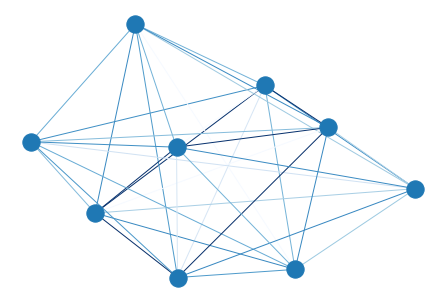

In [212]:
G = nx.from_numpy_matrix(df_dist.values)
nx.draw(G, edge_color = [i[2]['weight'] for i in G.edges(data=True)], edge_cmap = plt.cm.Blues)

In [213]:
D = df_dist.values
D[D <800] = 1
D[D >=800] = 0
D

array([[1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 1., 1., 0., 1., 0., 1., 1.],
       [1., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 1., 1., 0., 1., 0., 0., 1.]])

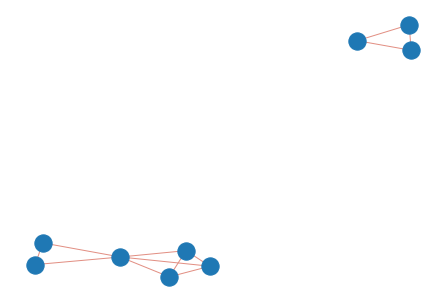

In [215]:
G = nx.from_numpy_matrix(D)
nx.draw(G, edge_color = '#E28F83')

### Training Testing Spilt

In [226]:
train = cities_df[0:6]
train

,house,lat,lon,x1,x2,y
0,h1,0.000069,0.000413,20,5,1200
1,h2,0.000101,0.000387,35,5,1500
2,h3,0.000153,0.000410,24,7,2000
3,h4,0.000120,0.000429,33,13,1780
4,h5,0.000070,0.000427,35,16,1450
5,h6,0.000124,0.000412,18,21,3000


In [227]:
test = cities_df[0:9]
test

,house,lat,lon,x1,x2,y
0,h1,0.000069,0.000413,20,5,1200
1,h2,0.000101,0.000387,35,5,1500
2,h3,0.000153,0.000410,24,7,2000
3,h4,0.000120,0.000429,33,13,1780
4,h5,0.000070,0.000427,35,16,1450
5,h6,0.000124,0.000412,18,21,3000
6,t1,0.226392,1.354236,19,6,1300
7,t2,0.331665,1.271656,32,6,1600
8,t3,0.500993,1.347394,23,6,1800


In [233]:
def geo_transform(df, m):
    df['lat'] = np.radians(df['lat'])
    df['lon'] = np.radians(df['lon'])
    
    dist = DistanceMetric.get_metric('haversine')
    
    df_dist = pd.DataFrame(dist.pairwise(df[['lat','lon']].to_numpy())*6373,  columns=df.house.unique(), index=df.house.unique())
    
    D = df_dist.values
    D[D < m] = 1
    D[D >= m] = 0
    
    G = nx.from_numpy_matrix(D)
    edge_index = from_networkx(G).edge_index
    
    x = torch.tensor(df[['x1','x2']].values, dtype=torch.float)
    y = torch.tensor(df[['y']].values, dtype=torch.float)
    
    data = Data(x=x, y=y, edge_index=edge_index)
    
    return edge_index, x, y, data

In [234]:
edge_index, x, y, data = geo_transform(train, 800)

In [235]:
edge_index_test, x_test, y_test, data_test = geo_transform(test, 800)

In [236]:
edge_index

tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
         4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5],
        [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
         0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

In [237]:
x

tensor([[20.,  5.],
        [35.,  5.],
        [24.,  7.],
        [33., 13.],
        [35., 16.],
        [18., 21.]])

In [238]:
y

tensor([[1200.],
        [1500.],
        [2000.],
        [1780.],
        [1450.],
        [3000.]])

In [239]:
data

Data(edge_index=[2, 36], x=[6, 2], y=[6, 1])

In [240]:
data_test

Data(edge_index=[2, 81], x=[9, 2], y=[9, 1])

In [21]:
# from torch.utils.data import DataLoader
# loader = DataLoader(data, batch_size=512, shuffle=True)

In [241]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j

In [242]:
import torch
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 2)
        self.conv2 = GCNConv(2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [252]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(data).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [253]:
num_epochs = 10000

model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    out = model(data)
    loss = MAPELoss(out, data.y)
    loss.backward()
  
    optimizer.step()
    # Print the progress
    if (epoch+1) % 1000 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1000/10000], Loss: 0.9901
Epoch [2000/10000], Loss: 0.7816
Epoch [3000/10000], Loss: 0.5773
Epoch [4000/10000], Loss: 0.3888
Epoch [5000/10000], Loss: 0.2661
Epoch [6000/10000], Loss: 0.5910
Epoch [7000/10000], Loss: 0.1997
Epoch [8000/10000], Loss: 0.2984
Epoch [9000/10000], Loss: 0.3477
Epoch [10000/10000], Loss: 0.2314


In [257]:
out

tensor([[1383.7874],
        [1795.9534],
        [1781.8550],
        [1529.2742],
        [1811.5730],
        [1383.7874]], grad_fn=<ScatterAddBackward>)

In [255]:
data.y

tensor([[1200.],
        [1500.],
        [2000.],
        [1780.],
        [1450.],
        [3000.]])

In [259]:
model(data_test)

tensor([[1343.0757],
        [1520.0787],
        [1515.5769],
        [1617.8693],
        [1525.1107],
        [1436.1665],
        [1602.4352],
        [1436.2610],
        [1433.9021]], grad_fn=<ScatterAddBackward>)

In [263]:
model(data)

tensor([[ 961.5178],
        [1239.0460],
        [ 826.8729],
        [ 826.8729],
        [1106.6467],
        [ 826.8729]], grad_fn=<ScatterAddBackward>)